#  Identifying Cellular Neighborhoods with Graph Neural Networks in Spatial Transcriptomics Data

### Project Introduction

This notebook tackles the challenge of unsupervised spatial domain segmentation in transcriptomics data. We represent a breast cancer tissue slice as a spatial graph, where each spot is a node with gene expression features. A Graph Autoencoder (GAE) with a Graph Convolutional Network (GCN) encoder is trained using a contrastive, link-prediction objective to learn low-dimensional node embeddings. We demonstrate that this unsupervised training process is sufficient to generate a latent space that clearly separates biologically distinct regions. By applying Leiden clustering to these final embeddings, we successfully segment the tissue into coherent neighborhoods corresponding to different cancer cell states and immune system responses.

The steps carried out in this notebook include:

  1. **Exploratory Data Analysis (EDA)**: a foundational EDA exploring the spatial data contained in the scanpy data object and aligning expression density with features in the image.

  2. **Graph Neural Network Modeling**: unsupervised modeling of the high-dimensional spatial expression with a Graph Autoencoder

  3. **Interetation and Visualization**: Visualizing differential expression on the final clusters we were able to assign specific biological identities to the spatially coherent neighborhoods the model discovered, including: regions of aggressive cell proliferation (marked by MALAT1, CCND1) and distinct types of immune cell infiltration (marked by CD74 and IG genes). 
  
This notebook demonstrates that an unsupervised GNN can learn and map the complex, interacting components of a tumor's ecosystem.

--- 
### References

**Data Sources and Platforms**
* [10X Genomics](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0): Invasive Ductal Carcinoma tissue.

**Libraries**
* [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

* [SquidPy Docs](https://squidpy.readthedocs.io/en/stable/)

* [ScanPy Docs](https://scanpy.readthedocs.io/en/stable/)

---
### Table of Contents

1. [Imports](#imports)
2. [Utility Functions](#utility-functions)
3. [Constants & Data Import](#constants-&-data-import)
4. [Data Exploration](#data-exploration)
5. [Data Pre-processing](#data-pre-processing)
6. [Build the Model](#build-the-model) 
7. [Clustering & Visualization](#clustering-&-visualization)
8. [Summary](#summary)

---
### 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges
from tqdm import tqdm

from tqdm.autonotebook import tqdm
from sklearn.preprocessing import StandardScaler

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/libpyg.

---
### 2. Utility Functions <a class="anchor" id="utility"></a>

#### Model Architecture

Define the Graph Autoencoder (GAE). This model has two parts:

  - An Encoder: The Graph Convolutional Network. Its job is to compress the high-dimensional
    gene expression of each node into a low-dimensional embedding.

  - A Decoder: It tries to reconstruct the original graph structure (the edges)
    from the learned embeddings.

The architecture of this model is based on the paper [Variational Graph Auto-Encoders](https://arxiv.org/abs/1611.07308) as we're aiming to build a model that will learn meaningful latent embeddings representing our gene expressions based on their relative locations within the sample.

The encoder is comprised of Graph Convolutioanl Networks from [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907). ([blog](https://tkipf.github.io/graph-convolutional-networks/))

In [2]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        """
        Initialize the GCNEncoder.

        Args:
            in_channels (int): Number of input features.
            out_channels (int): Number of output features.
        """
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels * 8)
        self.conv2 = GCNConv(out_channels * 8, out_channels * 4)
        self.conv3 = GCNConv(out_channels * 4, out_channels * 2)
        self.conv4 = GCNConv(out_channels * 2, out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the GCN layers.

        Args:
            x (torch.Tensor): Node features.
            edge_index (torch.Tensor): Graph connectivity.

        Returns:
            torch.Tensor: Node embeddings.
        """
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return x


class GAEModel(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        """
        Initialize the GAEModel.

        Args:
            in_channels (int): Number of input features.
            out_channels (int): Number of output features.
        """
        super(GAEModel, self).__init__()
        self.encoder = GCNEncoder(in_channels, out_channels)

    def encode(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Encode the input data to get latent embeddings.

        Args:
            x (torch.Tensor): Node features.
            edge_index (torch.Tensor): Graph connectivity.

        Returns:
            torch.Tensor: Latent embeddings.
        """
        return self.encoder(x, edge_index)

    def decode(
        self,
        z: torch.Tensor,
        pos_edge_index: torch.Tensor,
        neg_edge_index: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Decode the latent embeddings to predict edge existence.

        Args:
            z (torch.Tensor): Latent embeddings.
            pos_edge_index (torch.Tensor): Positive edge indices.
            neg_edge_index (torch.Tensor): Negative edge indices.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Positive and negative logits.
        """
        pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        return pos_logits, neg_logits

    def recon_loss(
        self, z: torch.Tensor, pos_edge_index: torch.Tensor
    ) -> Tuple[torch.Tensor, float]:
        """
        Compute the reconstruction loss and AUC score.

        Args:
            z (torch.Tensor): Latent embeddings.
            pos_edge_index (torch.Tensor): Positive edge indices.

        Returns:
            Tuple[torch.Tensor, float]: Reconstruction loss and AUC score.
        """
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=z.size(0),
            num_neg_samples=pos_edge_index.size(1),
        )

        pos_logits, neg_logits = self.decode(z, pos_edge_index, neg_edge_index)

        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        logits = torch.cat([pos_logits, neg_logits], dim=0)
        labels = torch.cat([pos_labels, neg_labels], dim=0)

        return F.binary_cross_entropy_with_logits(logits, labels), roc_auc_score(
            labels.detach().numpy(), logits.detach().numpy()
        )

#### Training Functions

In [3]:
def train(model, optimizer, data):
    """Train the model for one epoch.

    Returns:
        float: The reconstruction loss on the training edges.
    """
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    # calculate the loss on the training edges
    loss, auc_score = model.recon_loss(z, data.train_pos_edge_index)

    loss.backward()
    optimizer.step()
    return float(loss), auc_score


@torch.no_grad()
def test(model, data):
    """Evaluate the model on the validation edges.

    Args:
        pos_edge_index (torch.Tensor): The positive edge indices for validation.
    Returns:
        float: The reconstruction loss on the validation edges.
    """
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    loss, auc_score = model.recon_loss(z, data.val_pos_edge_index)

    return float(loss), auc_score

#### Plotting Helper Function

In [4]:
def plot_embeddings_umap(
    adata: sc.AnnData,
    embeddings: np.ndarray,
    embs_key: str,
    color_key: str,
    title: str,
    axes: plt.Axes = None,
    legend: str = "right margin",
) -> None:
    """
    Plots UMAP embeddings with specified color coding.

    Parameters:
    - adata (sc.AnnData): The annotated data object containing the embeddings.
    - embeddings (np.ndarray): The embeddings to plot.
    - embs_key (str): The key to store embeddings in adata.obsm.
    - color_key (str): The key for coloring the UMAP plot.
    - title (str): The title of the plot.
    - axes (plt.Axes, optional): The axes to plot on. If None, new axes are created.
    """

    if axes is None:
        _, axes = plt.subplots(figsize=(8, 8))

    scaler = StandardScaler()

    # Store the "before" embeddings in adata.obsm
    adata.obsm[embs_key] = embeddings
    # Compute neighbors and UMAP based on these UNTRAINED embeddings
    sc.pp.neighbors(adata, use_rep=embs_key)
    sc.tl.umap(adata, min_dist=0.5, random_state=42)

    adata.obsm["X_umap"] = scaler.fit_transform(adata.obsm["X_umap"])

    # Plot the result, but COLOR by the FINAL cluster assignments
    sc.pl.umap(
        adata,
        color=color_key,  # Use final clusters for coloring
        ax=axes,
        show=False,
        title=title,
        palette="tab20",
        legend_loc=legend,
    )
    axes.set_aspect("equal", adjustable="box")
    axes.set_xlim([-2.5, 2.5])
    axes.set_ylim([-2.5, 2.5])


---
### 3. Constants & Data Import <a class="anchor" id="constants"></a>


The necessary data files can be accessed and downloaded via the [10X Genomics Datasets Site](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0). The following specific datasets are required:

* **Filtered feature barcode matrix**

    *V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix* 
    
    This is your core gene expression data that contains a matrix where the rows are genes and the columns are the unique barcodes for each spot on the tissue slide.

* **Spatial imaging data**

    *V1_Breast_Cancer_Block_A_Section_1_spatial.tar.gz*

    Compressed folder contains all the crucial spatial information including files like tissue_positions.csv, which has the exact (x, y) pixel coordinates for every spot/barcode. 

* **Tissue Image**

    *V1_Breast_Cancer_Block_A_Section_1_image.tif*

    High-resolution H&E stained image of the tissue slice


The notebook expects both tsv files to be placed in the `data/10x` folder.

In [5]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "10x")
SPATIAL_DATA_PATH = os.path.join(DATA_PATH, "spatial")
H5_DATA_PATH = os.path.join(
    DATA_PATH, "V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5"
)

---
### 4. Data Exploration <a class="anchor" id="constants"></a>

Load the data into an AnnData object

In [6]:
adata = sc.read_visium(path=DATA_PATH, count_file=H5_DATA_PATH)
adata.var_names_make_unique()  # Ensure gene names are unique
adata

/var/folders/wt/5vc39b651nn6m5wm29j25dk80000gn/T/ipykernel_26211/2461471614.py:1: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path=DATA_PATH, count_file=H5_DATA_PATH)
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

#### Pre-process the data

In [7]:
sc.pp.filter_genes(
    adata, min_cells=10
)  # Filter out genes expressed in fewer than 10 spots
sc.pp.normalize_total(adata, inplace=True)  # Normalize counts per spot
sc.pp.log1p(adata)  # Log-transform the data
# Calculate quality control metrics, adding total_counts (total number of gene counts per spot)
sc.pp.calculate_qc_metrics(adata, inplace=True)

adata

AnnData object with n_obs × n_vars = 3798 × 19690
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

#### Explore the data object

**adata.uns, adata.obsm**

Display the image of the slide from`adata.uns` and plot the scatter plot from the spatial spot coordinates from `adata.obsm` (colored by the total counts in `adata.obs` to indicate expression per spot).

dict_keys(['images', 'scalefactors', 'metadata'])
{'chemistry_description': "Spatial 3' v1", 'software_version': 'spaceranger-1.1.0'}
None


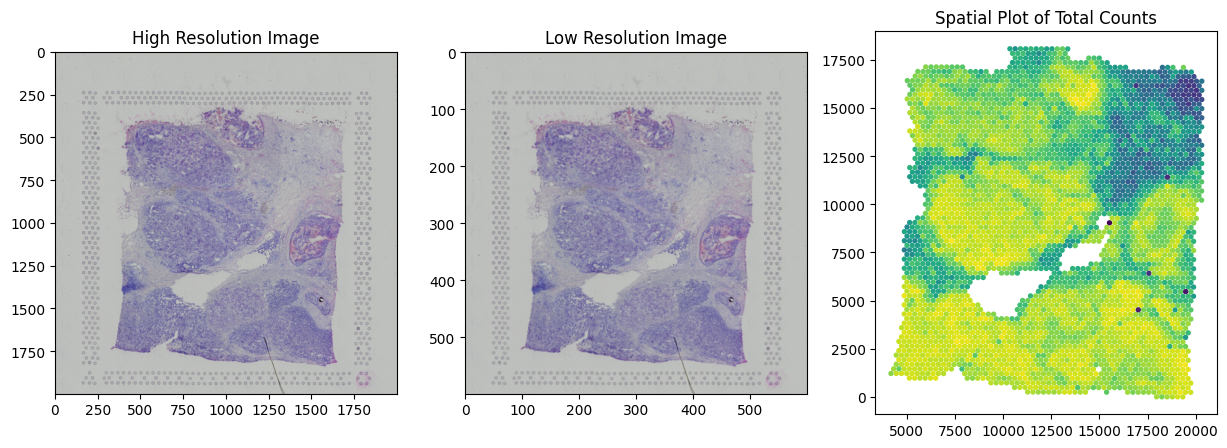

In [8]:
print(adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"].keys())
print(print(adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["metadata"]))
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(
    adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["hires"]
)
axes[0].set_title("High Resolution Image")

axes[1].set_title("Low Resolution Image")
axes[1].imshow(
    adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["lowres"]
)

axes[2].scatter(
    x=adata.obsm["spatial"][:, 0],
    y=adata.obsm["spatial"][:, 1] * -1
    - min(adata.obsm["spatial"][:, 1] * -1),  # invert y-axis
    c=adata.obs["total_counts"],
    cmap="viridis",
    s=8,
)
axes[2].set_title("Spatial Plot of Total Counts")
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")
axes[2].set_aspect("equal")


**adata.var**

Each row in adata.var corresponds to a single gene. The important columns in adata.var for this notebook include:

* `gene_ids`: The Ensembl ID for the gene.
* `feature_types`: The type of featureb entirely "Gene Expression" for this data.
* `genome`: The reference genome used.
* `n_cells`: A column added by scanpy after filtering, showing in how many spots (cells) each gene was detected.
* `total_counts`: A quality control metric showing the total number of counts for each gene across all spots.
* `mean_counts`: average expression across the data set
* `log1p_mean_counts`: log-transformed version of `mean_counts`

In [9]:
print(adata.var.shape)
adata.var.head(2)

(19690, 10)


gene_ids    feature_types  genome  n_cells  \
AL627309.1  ENSG00000238009  Gene Expression  GRCh38      118   
AP006222.2  ENSG00000286448  Gene Expression  GRCh38       15   

            n_cells_by_counts  mean_counts  log1p_mean_counts  \
AL627309.1                118     0.018013           0.017853   
AP006222.2                 15     0.002494           0.002491   

            pct_dropout_by_counts  total_counts  log1p_total_counts  
AL627309.1              96.893102     68.412788            4.240071  
AP006222.2              99.605055      9.472625            2.348765

**adata.var**

Each row in adata.obs corresponds to a observation, or spot on the tissue slide. The important columns in adata.obs for this notebook include:

* `in_tissue`: A binary column (0 or 1) indicating whether the spot is located over the actual tissue section (1) or in the background (0).
* `array_row` and `array_col`: These are the integer row and column coordinates of the spot on the physical grid of the Visium slide.
* `total_counts`: This is the total number of gene transcripts (UMIs) detected in that specific spot. It's a measure of the sequencing depth or "library size" for that spot. 
* `n_genes_by_counts`: The number of unique genes that were detected in that spot. A very low number might indicate a low-quality spot.
* `log1p_total_counts`: The log-transformed version of total_counts.

In [10]:
print(adata.obs.shape)
adata.obs.head(2)

(3798, 11)


in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               4403   
AAACACCAATAACTGC-1          1         59         19               8984   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.390268   6018.627441            8.702781   
AAACACCAATAACTGC-1                 9.103312   7362.225098            8.904253   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                    3.652838                     6.624900   
AAACACCAATAACTGC-1                    2.917385                     5.366046   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  
AAACAAGTATCTCCCA-1                    11.541192                    22.751365  
AAACACCAATAACTGC-1                     9.465522                    18.650963

Construct a graph using squidpy's 'spatial_neighbors' function which builds a graph by connecting each spot to its nearest neighbors.  The hue on the scatter plot corresponds to the total number of gene transcripts detected in each spot.

spatial_connectivities: (3798, 3798)
spatial_distances: (3798, 3798)


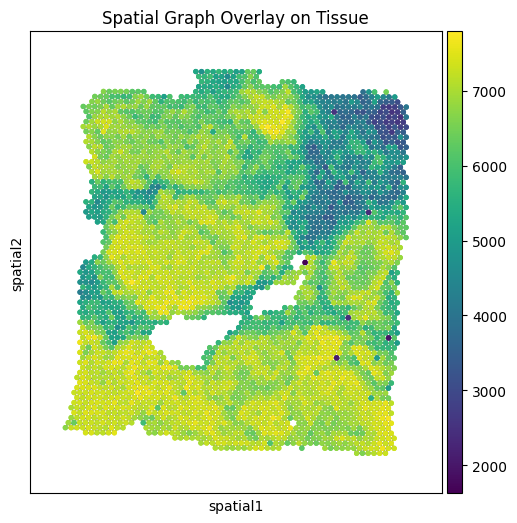

In [11]:
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
for k, v in adata.obsp.items():
    print(f"{k}: {v.shape}")

_, axes = plt.subplots(figsize=(6, 6))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",  
    color="total_counts",  
    shape=None,
    connectivity_key="spatial_connectivities",  
    title="Spatial Graph Overlay on Tissue",
    ax=axes,
)

**Observations**: 
* This slide contains 3,798 spots and 19,690 genes sampled.
* Total counts seem to correlate with cell density. The areas with the highest total_counts (the bright yellow spots) visually align with the densest, most purple regions in the H&E image. Conversely, the blue/darker areas with lower counts correspond to less dense regions (like stroma or connective tissue).
* The clear spatial pattern of high-count and low-count regions demonstrates that the tissue is heterogeneous. This heterogeneity should be leveraged by our GNN to learn if and where there are different types of genes being expressed.

---
### 5. Data Pre-processing <a class="anchor" id="model"></a>

Process the data into nodes and edges conducive to modeling with the torch geometric GNN.

Critical data for the GNN will be 
* `adata.X`: a sparse matrix that is n (number of spots) x m (number of genes) in size that contains gene expression at each spot.
* `adata.obs['spatial_connectivities']`: the graph adjacency matrix

Visualize the gene expression matrix

In [12]:
top_ten_highest_gene_idx = np.argsort(adata.X.toarray().mean(axis=0))[::-1][:20]
bottom_ten_highest_gene_idx = np.argsort(adata.X.toarray().mean(axis=0))[::-1][-20:]

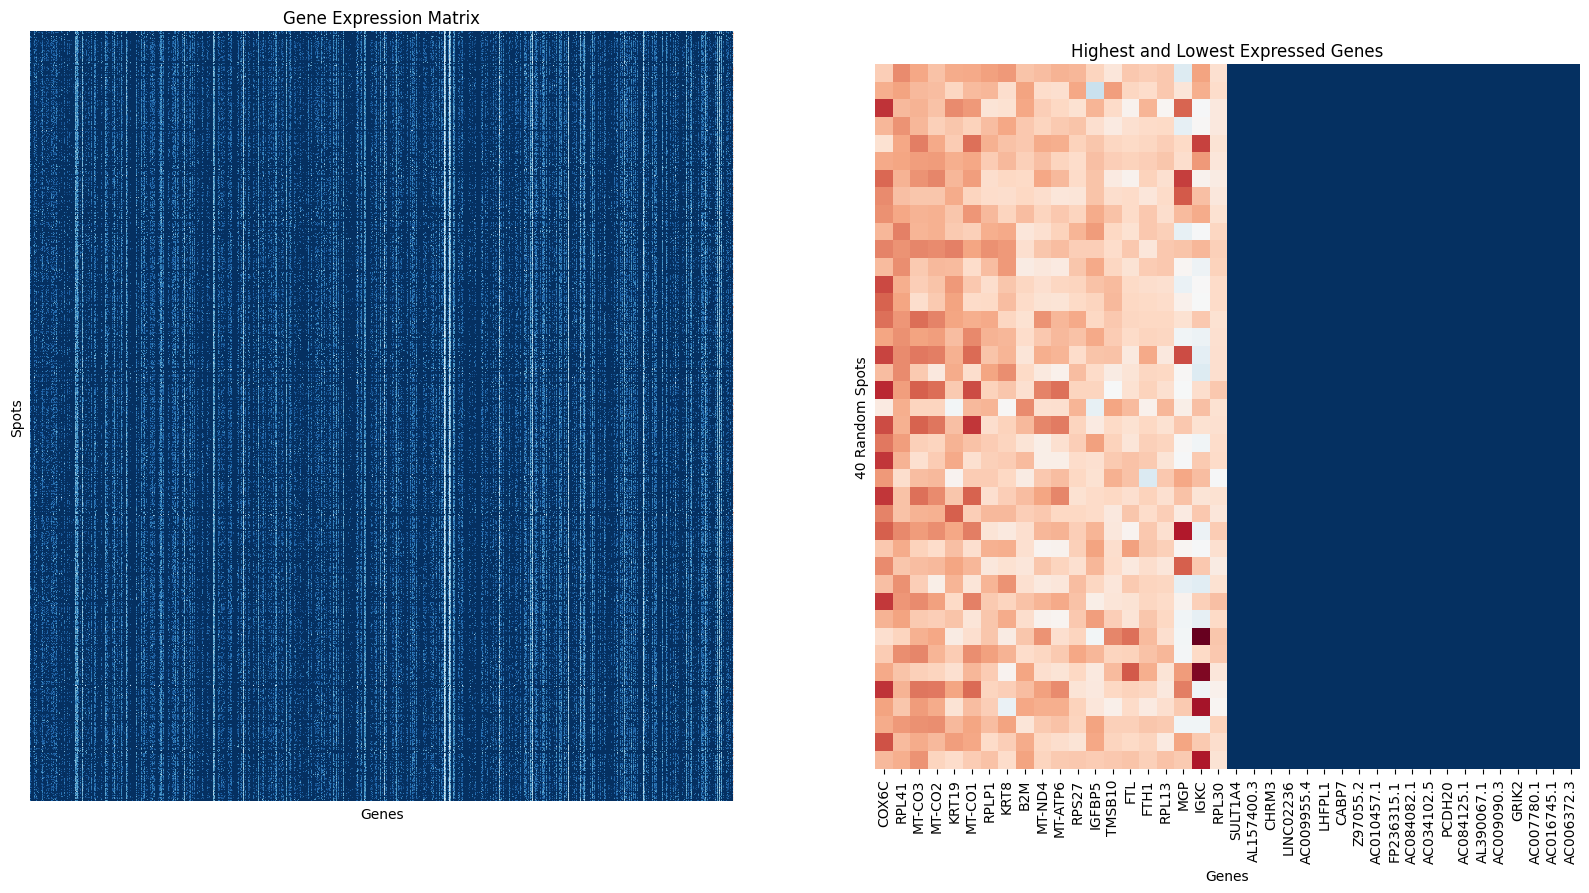

In [13]:
random_sample_of_spots = np.random.randint(0, adata.X.toarray().shape[0], 40)

sample_array = np.concat(
    [
        adata.X.toarray()[random_sample_of_spots, :][:, top_ten_highest_gene_idx],
        adata.X.toarray()[random_sample_of_spots, :][:, bottom_ten_highest_gene_idx],
    ],
    axis=1,
)

_, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(
    adata.X.toarray(),
    cmap="RdBu_r",
    cbar_kws={"label": "Expression Level"},
    xticklabels=[],
    yticklabels=[],
    cbar=False,
    square=False,
    ax=axes[0],
)

sns.heatmap(
    sample_array,
    cmap="RdBu_r",
    cbar_kws={"label": "Expression Level"},
    xticklabels=np.concatenate(
        [
            adata.var_names[top_ten_highest_gene_idx],
            adata.var_names[bottom_ten_highest_gene_idx],
        ]
    ),
    yticklabels=[],
    cbar=False,
    square=True,
    ax=axes[1],
)

axes[0].set_title("Gene Expression Matrix")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Spots")

axes[1].set_title("Highest and Lowest Expressed Genes")
axes[1].set_xlabel("Genes")
axes[1].set_ylabel(f"{len(random_sample_of_spots)} Random Spots");

Some genes have relatively high expression over all spots in the slide indicated by the vertical lines in the heatmap above while others aren't expressed at all.

Convert the spatial connectivites from it's native matrix to COOrdinate sparse matrix. This format has three key components:

1. .row: A list of row indices for every non-zero element.
2. .col: A list of column indices for every non-zero element.
3. .data: A list of the actual values at those (row, col) positions

In [14]:
adata.obsp["spatial_connectivities"]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22064 stored elements and shape (3798, 3798)>

In [15]:
adata.obsp["spatial_connectivities"].tocoo()

<COOrdinate sparse matrix of dtype 'float64'
	with 22064 stored elements and shape (3798, 3798)>

In [16]:
edge_index_coo = adata.obsp["spatial_connectivities"].tocoo()
edge_index = torch.tensor(
    np.vstack([edge_index_coo.row, edge_index_coo.col]), dtype=torch.long
)

edge_index

tensor([[   0,    0,    0,  ..., 3797, 3797, 3797],
        [ 397,  487, 1087,  ..., 2399, 2614, 3563]])

In this edge_index coordinate representation, we see each node connected to at most 6 other nodes and both directions counted (i.e., node_a ==> node_b and node_b ==> node_a).

In [17]:
edges_per_node = pd.DataFrame(edge_index.flatten()).value_counts().values

edge_per_node_counts, edge_per_node_values = np.histogram(
    edges_per_node, bins=np.linspace(0, 15, 16)
)
pd.DataFrame(
    data=np.array([edge_per_node_values[:-1], edge_per_node_counts]).T,
    columns=["Number of Edges", "Counts"],
).sort_values("Counts", ascending=False).iloc[:6]

Number of Edges  Counts
12             12.0  3428.0
8               8.0   139.0
10             10.0   129.0
6               6.0    91.0
4               4.0    11.0
0               0.0     0.0

PyTorch Geometric models require a specific 'Data' object that holds the graph structure. Convert the Snapy AnnData to a compatible structure - COO (adjacency matrix) format for edges and dense torch tensor for the nodes (gene expression matrix).

In [18]:
# Edges - we will use the spatial connectivities computed by Squidpy
edge_index_coo = adata.obsp["spatial_connectivities"].tocoo()
edge_index = torch.tensor(
    np.vstack([edge_index_coo.row, edge_index_coo.col]), dtype=torch.long
)

# Nodes - we will use the gene expression matrix as node features
x = torch.tensor(adata.X.toarray(), dtype=torch.float)

# Create the PyG Data object
data = Data(x=x, edge_index=edge_index)
print("--- PyTorch Geometric Data Object ---")
print(data)

# Split edges into training, validation, and test sets
data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)

--- PyTorch Geometric Data Object ---
Data(x=[3798, 19690], edge_index=[2, 22064])


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


---
### 6. Build the Model <a class="anchor" id="model"></a>

Define model parameters

In [19]:
in_channels = data.num_features  # Number of genes
out_channels = 32  # Desired size of the embedding for each spot

In [20]:
model = GAEModel(in_channels, out_channels)

# move model, data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

Train the model

In [21]:
NUM_EPOCHS = 500

pbar = tqdm(range(1, NUM_EPOCHS + 1))
animation_data = []

for epoch in pbar:
    # Get embeddings for visualization
    model.eval()
    with torch.no_grad():
        full_z = model.encode(data.x, edge_index)

    train_loss, train_auc = train(model, optimizer, data)
    val_loss, val_auc = test(model, data)

    animation_data.append(
        {
            "epoch": epoch,
            "val_auc": val_auc,
            "train_auc": train_auc,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "embeddings": full_z,
        }
    )

    # Update the progress bar's description with the current loss
    pbar.set_description(
        f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

Epoch 500 | Train Loss: 0.5587 | Val Loss: 0.5844: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


**What did the model learn?**

Plot the learning objective (BCE Loss) as well as the link-prediction classification AUC to visualize how the model learned to improve performance on its specific technical task (link-prediction).

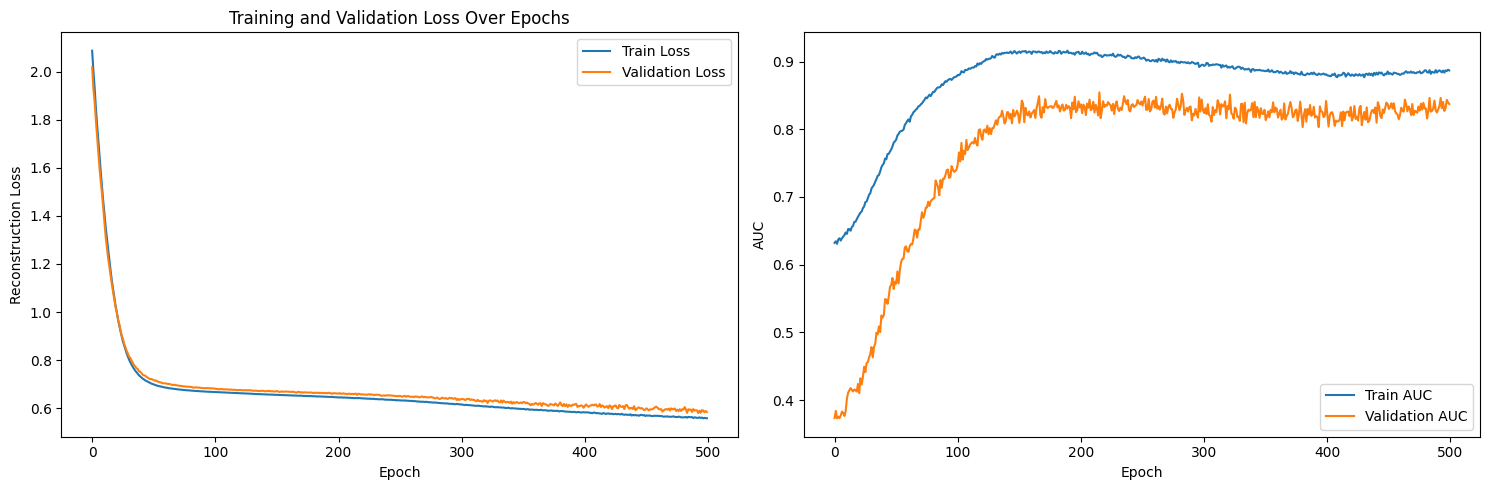

In [22]:
_, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
axes[0].plot([x["train_loss"] for x in animation_data], label="Train Loss")
axes[0].plot([x["val_loss"] for x in animation_data], label="Validation Loss")
axes[0].set_title("Training and Validation Loss Over Epochs")
axes[0].set_ylabel("Reconstruction Loss")
axes[0].legend()
axes[0].set_xlabel("Epoch")

axes[1].plot([x["train_auc"] for x in animation_data], label="Train AUC")
axes[1].plot([x["val_auc"] for x in animation_data], label="Validation AUC")
axes[1].set_ylabel("AUC")
axes[1].legend()
axes[1].set_xlabel("Epoch")
plt.tight_layout()

**Observations**:
- In simple terms, this GNN learns a spatially-aware latent representation of the gene expression. Its GCN layers are built on the principle that local neighborhoods matter, and its contrastive loss function trains it to make the embeddings of neighboring nodes similar while making the embeddings of non-neighboring nodes dissimilar

---
### 7. Clustering & Visualization <a class="anchor" id="model"></a>

#### Perform Clustering on the GCN Embeddings

Run the Leiden clustering algorithm.  The Leiden algorithm is a powerful community detection algorithm used to find groups of nodes that are more densely connected to each other than to the rest of the graph.

In [23]:
adata.obsm["GCN_embeddings"] = animation_data[-1]["embeddings"].cpu().numpy()
sc.pp.neighbors(adata, use_rep="GCN_embeddings")

sc.tl.leiden(
    adata,
    resolution=0.5,
    key_added="GCN_leiden_clusters",
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
adata.obs["GCN_leiden_clusters"].value_counts()

GCN_leiden_clusters
12    449
1     424
3     412
4     395
9     394
6     379
7     332
8     200
0     186
11    147
2     137
10    131
13    111
5     101
Name: count, dtype: int64

#### What useful biological structure has the model learned?

Use squidpy's plotting function to color each spot on the tissue image according to its assigned cluster ID. This reveals the spatial organization of the cellular neighborhoods identified by the GNN. In the same pannel, use UMAP to visualize how the embeddings cluster in 2D space colored by their Leiden assignments.

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


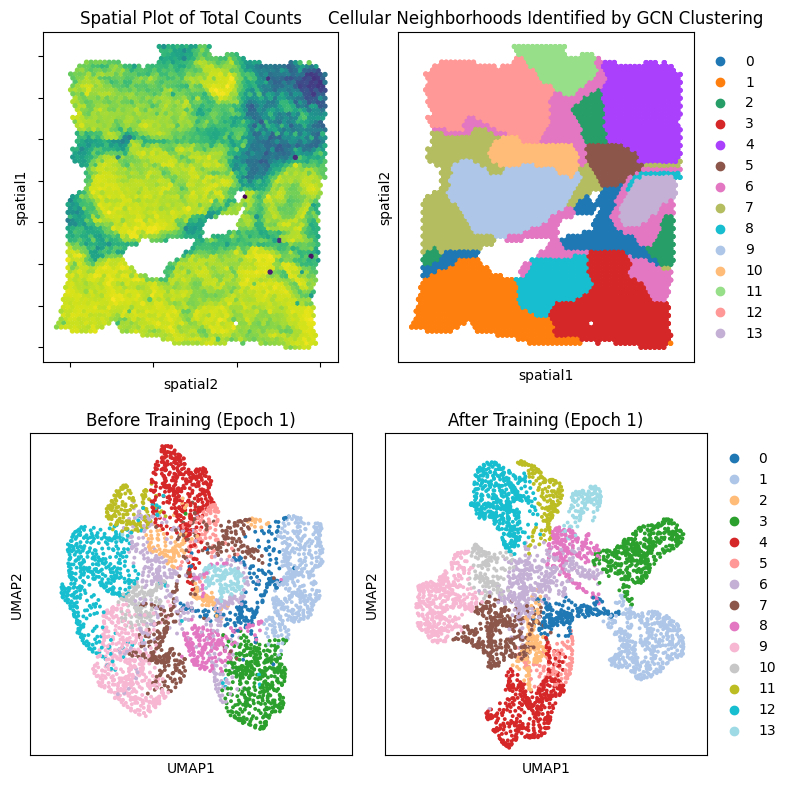

In [24]:
_, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0, 0].scatter(
    x=adata.obsm["spatial"][:, 0],
    y=adata.obsm["spatial"][:, 1] * -1
    - min(adata.obsm["spatial"][:, 1] * -1),  # invert y-axis
    c=adata.obs["total_counts"],
    cmap="viridis",
    s=8,
)
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color="GCN_leiden_clusters",
    shape=None,
    title="Cellular Neighborhoods Identified by GCN Clustering",
    ax=axes[0, 1],
)

embeddings_before = animation_data[0]["embeddings"].cpu().numpy()
embeddings_after = animation_data[-1]["embeddings"].cpu().numpy()

plot_embeddings_umap(
    embeddings=embeddings_before,
    adata=adata,
    embs_key="GCN_before_training",
    color_key="GCN_leiden_clusters",
    title="Before Training (Epoch 1)",
    axes=axes[1, 0],
    legend=None,
)

plot_embeddings_umap(
    embeddings=embeddings_after,
    adata=adata,
    embs_key="GCN_after_training",
    color_key="GCN_leiden_clusters",
    title="After Training (Epoch 1)",
    axes=axes[1, 1],
)

axes[0, 0].set_title("Spatial Plot of Total Counts")
axes[0, 0].set_xlabel("spatial2")
axes[0, 0].set_ylabel("spatial1")
axes[0, 0].set_xticklabels([])
axes[0, 0].set_yticklabels([])

axes[0, 0].set_aspect("equal")
axes[1, 0].set_aspect("equal")
axes[1, 1].set_aspect("equal")

plt.tight_layout()

**Takeaways** 

* **Inherent Structural Bias of the GCN Architecture:** Even prior to training, a single forward pass through the randomly initialized GNN reveals significant structure in the data. The GCN's core operation of neighborhood aggregation acts as a spatial smoother, providing a strong structural prior that is sufficient to achieve an effective baseline separation of several distinct cellular neighborhoods even before training.  Interestingly, clusters 0, 2 and 7 are "discovered" after training.

* **GNN Training Creates Structure from Noise**: In the "Before Training" plot, the different colors (representing the final clusters) are largely mixed together in a single, dense cloud. After training, those same colors have separated into distinct, well-defined continents. This is visual proof that the training process successfully taught the model to distinguish between the different cellular neighborhoods, forcing their learned representations apart in the embedding space.

* **Link Prediction is a Powerful Objective for Unsupervised Learning:** By training the model on the simple, unsupervised task of predicting local connections (links), it was forced to learn high-level biological concepts about the different types of tissue present in the sample. This directly connects the improving AUC score to a tangible, useful outcome: the ability to segment the tissue into meaningful biological regions.

Identify the genes that are most significantly up-regulated in each cluster using a t-test to find differentially expressed genes.

In [25]:
sc.tl.rank_genes_groups(
    adata, groupby="GCN_leiden_clusters", method="t-test", key_added="marker_genes"
)

# Visualize top marker genes for each cluster
pd.DataFrame(adata.uns["marker_genes"]["names"]).head(5)

0        1        2        3       4       5       6      7  \
0  RPLP1   CXCL14       C3   CRISP3  MALAT1  MALAT1     MGP   CD74   
1   RPL8    CCND1  HLA-DRA  SLITRK6   TIMP1   IGLC2   IGHG1   APOE   
2  AEBP1    GFRA1     CD74  S100A13      C3   IGHG3    IGKC   C1QA   
3  IGLC2  S100A11    TIMP1   IGFBP5     MGP      C3   IGLC1  APOC1   
4  IGHG3     KRT8    IGLC2   SERHL2  CCDC80    IGKC  S100A6    FTL   

            8          9         10     11         12      13  
0        CD24       CPB1  LINC00645    MGP      COX6C     MGP  
1       S100G      IL6ST     ZNF703  S100G    SLC39A6     DSP  
2  AC087379.2  LINC02224      MUC5B  IFI27      WFDC2   RPL26  
3       KRT37        CFB    SLC39A6    ALB       SNCG  IGFBP5  
4      IFT122      COX6C      PVALB   CSTA  RAB11FIP1    LDHA

Create a dot plot of the top 4 marker genes for each cluster 

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:138: UserWarning: You’re trying to run this on 19690 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)


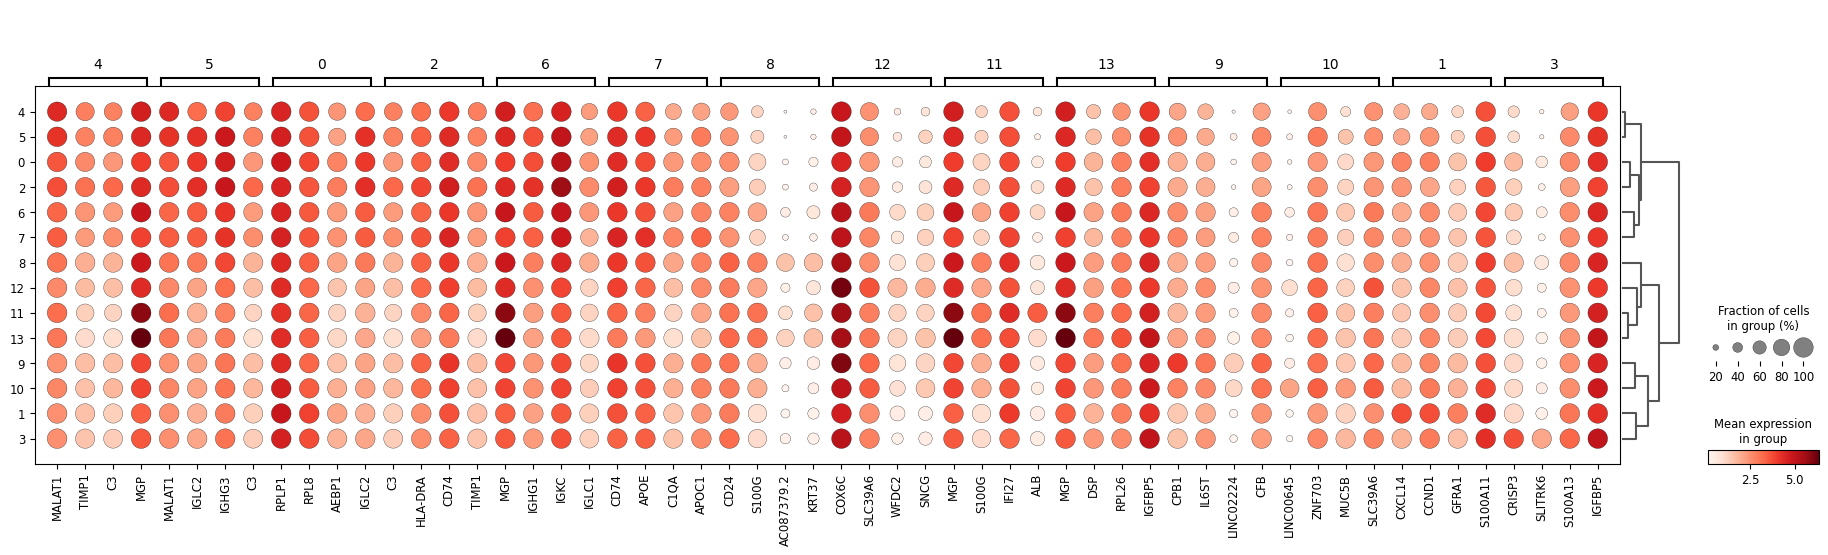

In [26]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=4, key="marker_genes", groupby="GCN_leiden_clusters"
)

Plot the spatial expression of the top 3 genes from each cluster to uncover biological and oncological characteristics of each cellular neighborhood.

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:9

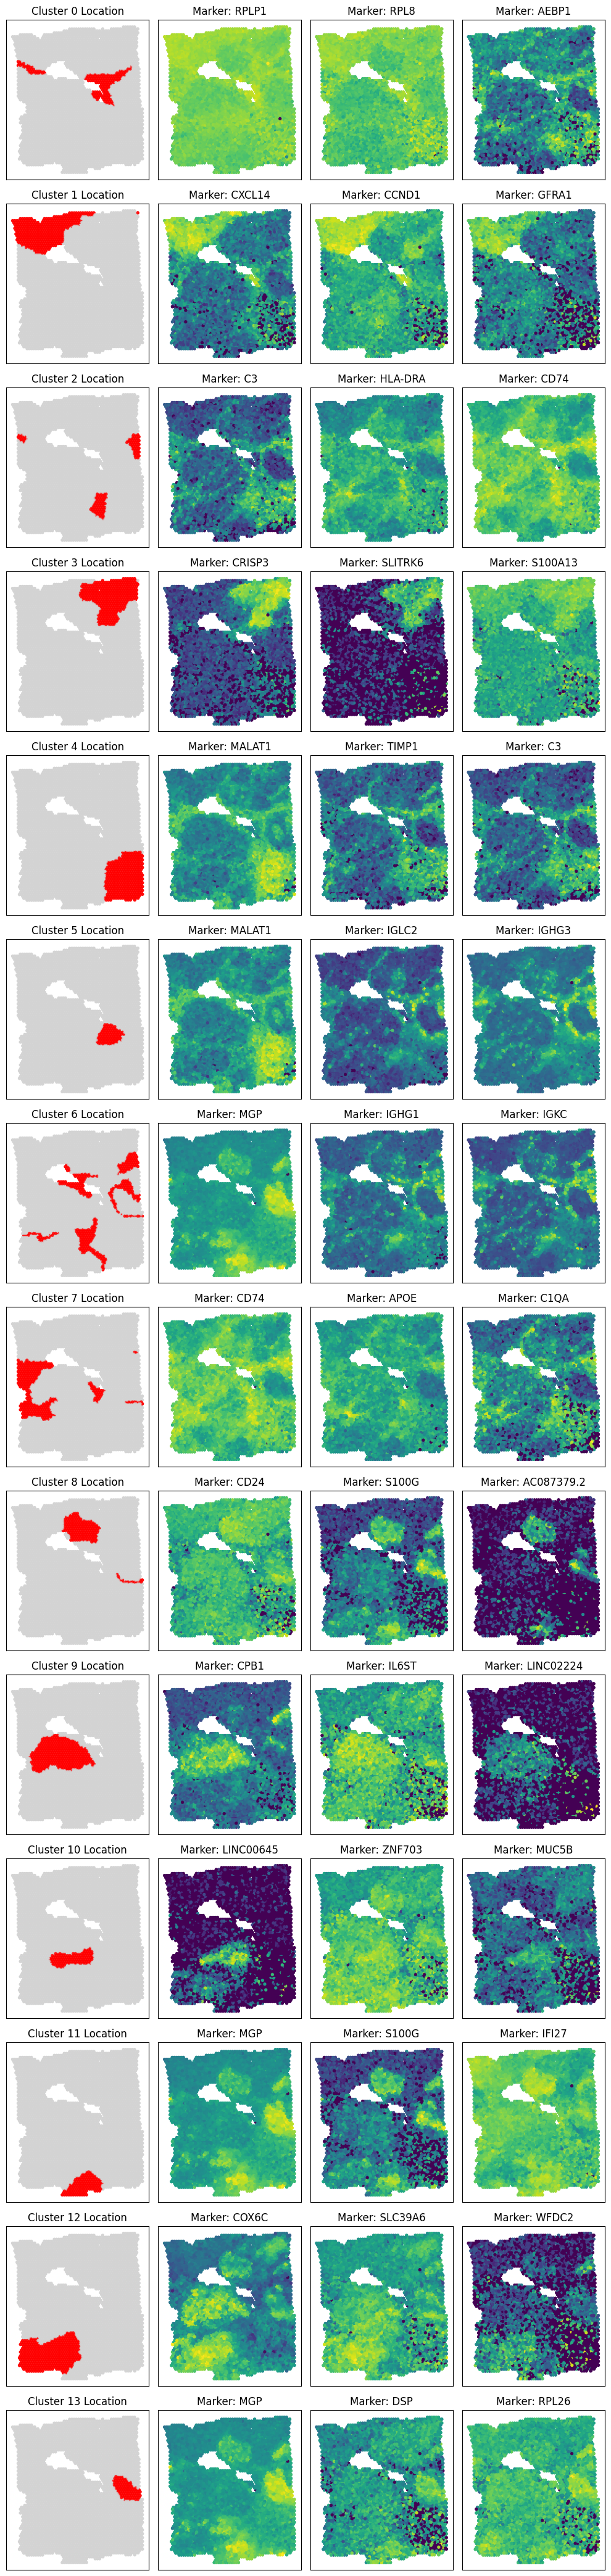

In [27]:
# Get the unique cluster IDs, sorted numerically
clusters = sorted(adata.obs["GCN_leiden_clusters"].unique().astype(int))

# Create a new figure and a 1x4 grid of subplots for each cluster
fig, axes = plt.subplots(
    len(clusters), 4, figsize=(10, 3 * len(clusters)), sharey=True, sharex=True
)

for idx, cluster in enumerate(clusters):
    # Create a temporary column to highlight just the current cluster
    highlight_key = f"cluster_{cluster}_highlight"
    adata.obs[highlight_key] = [
        "This Cluster" if c == str(cluster) else "Other"
        for c in adata.obs["GCN_leiden_clusters"]
    ]

    adata.obs[highlight_key] = adata.obs[highlight_key].astype("category")

    adata.uns[f"{highlight_key}_colors"] = ["lightgrey", "red"]
    sq.pl.spatial_scatter(
        adata,
        library_id="spatial",
        color=highlight_key,
        ax=axes[idx][0],
        shape=None,
        alpha=0.7,
        title=f"Cluster {cluster} Location",
        legend_loc=None,
    )

    top_marker_genes = adata.uns["marker_genes"]["names"][str(cluster)][:3]
    for i, gene in enumerate(top_marker_genes):
        ax_index = i + 1
        sq.pl.spatial_scatter(
            adata,
            library_id="spatial",
            color=gene,
            shape=None,
            ax=axes[idx][ax_index],
            title=f"Marker: {gene}",
            colorbar=False,
            cmap="viridis",
        )

    for ax in axes[idx]:
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_aspect("equal")

    plt.tight_layout()

**Observations**
* The GNN successfully segmented the tissue into distinct, spatially coherent clusters that correspond to real, localized biological niches each defined by a unique top gene.

* The embeddings are high-quality - after training, the clusters formed well-separated continents in the latent space meaning the GCN learned distinct feature representations for each neighborhood.

* The clusters correspond to biological effects based on the fact that the GCN Clusters appear in similar locations to the features in the Total Counts plot as well as regions of localized gene expression. Key Takeaways:

  * **The Model Identified a Proliferative Hotspot of Aggressive Cancer:** 
  
     * Cluster 4 & 5's MALAT1 is a long non-coding RNA linked to metastasis by interfering with tumor suppressor pathways.
     * Cluster 1's CCND1 is an oncogene that is a core driver of the cell cycle - overexpression is associated with tumor growth.  Interestingly, cluster 1 also demonstrates high CXCL14 suggesting an immune response (CXCL14 is associated with attracting and activating immune cells (DCs, NKs) and increasing the expression of MHC-I)

  * **The Model Mapped a Diverse and Spatially Organized Immune Response:** The GNN distinguishes between several different types of immune activity:

    * Cluster 2 & 7, with markers like CD74 and HLA-DRA, represent neighborhoods rich in antigen-presenting cells.  
    * Cluster 5 & 6, with IGLC2 and IGHG3 signals, identifies areas of antibody-secreting plasma cells and B-cells, indicating regions of adaptive immune response.

**Interestingly, these regions of immunological significance were poorly defined prior to training where the initial "smoothing" effect of the first pass GCN identified these areas as one big area with no granular distinction.  The training process allowed the model to decompose this area into more nuanced regions of B-cell rich (IGLC2, IGHG3) and macrophage/APC areas.**
    


---
### 8. Summary

This project demonstrates the power of Graph Neural Networks (GNNs) to perform unsupervised pattern recognition on complex spatial transcriptomics data. By representing the tissue slice as a spatial graph, we trained a Graph Autoencoder (GAE) with a Graph Convolutional Network (GCN) encoder to learn a low-dimensional latent representation for each spatial location.

The model was trained on a purely self-supervised, contrastive objective: predicting the existence of links between nodes. The steady increase in the validation AUC score during training showed the model was successfully learning to distinguish between connected and unconnected nodes. Before training, the latent space was disorganized with coarse regions (e.g., regions of immunological cells); after training, the embeddings formed distinct, well-separated clusters corresponding to the final cellular neighborhoods (e.g., B-cell areas vs. Antigen Presenting Cells (APCs)).

Ultimately, this demonstrates that by learning the simple rules of spatial proximity, the GNN was able to deconstruct the complex tumor microenvironment into its constituent biological parts. It successfully identified and segmented distinct neighborhoods corresponding to aggressive cell proliferation (marked by CCND1), various types of immune infiltration (CD74, S100 genes), and the supporting stromal architecture (MGP), proving that this AI-driven approach is a powerful tool for unbiased biological discovery.


The primary findings include:

* **The GNN Identified Nuanced Immunological Regions**: After a first pass through the GNN, the embeddings displayed some structure based on easily distinguished features that were grossly different, such as dense regions of tumor cells vs. sparse regions of stromal cells.  However, after training the model learns to deconstruct the complex tumor immune microenvironment, resuolving fine-grained differences like those in high B-cell regions vs. areas of high macrophage and APC expression.  The model successfully learned a representation that captures the spatial organization of different, co-located immune cell populations.

* **Graph Networks are Uniquely Suited for Spatial Transcriptomics**: Standard machine learning models ignore the physical location of cells. By representing the tissue slice as a graph and applying a Graph Convolutional Network (GCN), we were able to learn from both the gene expression of each spot and its surrounding neighborhood. The model was trained on the unsupervised, contrastive task of link prediction, which forced it to learn a low-dimensional embedding space that captured the tissue's complex spatial architecture. The animation of the training process clearly showed the model learning to organize this embedding space over time, directly linking an improving AUC score to a more structured representation of the data.

* **The GNN Successfully Deconstructed the Tumor Microenvironment (TME):** The unsupervised model didn't just separate "tumor" from "not tumor." It independently learned to parse the complex tissue into its distinct functional components. The plots clearly delineate multiple types of cancer cell states, different kinds of immune infiltrates, and the supporting stroma, providing a detailed map of the tumor's ecosystem.

Next Steps:
* Investigate the effect of different model architectures on the results. 
  * How do deeper networks affect the embeddings?
  * What's the effect of different latent dimensions?